## Robot localization using particle filter
The robot has steering and velocity control inputs. It has sensors that measures distance to visible landmarks. Both the sensors and control mechanism have noise in them, and we need to track the robot's position.

In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.animation as animation 

from IPython.display import HTML
from matplotlib.patches import Circle

# set print options
np.set_printoptions(threshold=3)
np.set_printoptions(suppress=True)

## Draw the maps with landmarks

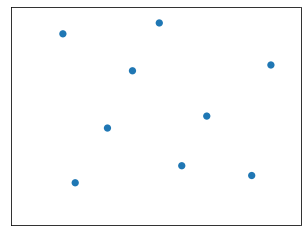

In [61]:
img = plt.imread('img/Canvas.png')

fig,ax = plt.subplots(1)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_position(('data', 800))
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_position(('data', 600))
# Create a figure. Equal aspect so circles look circular
ax.set_aspect('equal')

# Don't use any ticks to make the image more visible
plt.xticks([])
plt.yticks([])

# Show the image
ax.imshow(img)

# set landmarks in the map randomly
# landmarks=np.random.uniform([0,0], [Width_Max,Height_Max], [N_Landmarks,2])
centers = np.array([ [144,73], [410,43], [336,175], [718,159], [178,484], [665,464], [267, 333], [541, 300], [472, 437] ])
radius=10

# Now, loop through coord arrays, and create a circle at center
for count, value in enumerate(centers):
    circ = Circle(value,radius)
    ax.add_patch(circ)

# Show the map with landmarks
plt.show()

In [23]:
# set the number of particles N and landmarks, freely change
# these hyperparameters to see the corresponding influence
N = 50
N_Landmarks = len(centers)

# Initialization of all particle weights to 1
weights = np.ones((N, 1))

# set the moving regions
[Width_Max, Height_Max]= [800, 600]
# Create a black image, a window and bind the function to window
img = np.zeros((Height_Max,Width_Max,3), np.uint8)

## Constuct particles randomly
Particles can be constructed by randomly sampling in the 2D space. Each particle has a weight (probability) indicating how likely it matches the actual state of the system.

In [59]:
def Uniform_Particles_Construction(width, height, N):
    particles = np.zeros((N, 2))
    # set the random seed so that we have reproducible experiments
    np.random.seed(500)
    # randomly draw particles from the 2D space
    particles = np.random.uniform([0,0], [width, height], size=(N, 2))
    return particles

## Rejection sampling
Since previous we get particles randomly among the total 2D spaces, it is possible that there are some particles located in the landmarks, thus we neet to delete these invalid particles.

In [7]:
def Rejection_Sampling(particles, centers, radius):
    """Given randomly sampled particles and centers of landmarks, perform rejection here
    
    Args:
        particles:
        centers:
        radius: the radius of cicular landmarks 
    """
    for count_p, coord_p in enumerate(particles):
        dis = np.linalg.norm(coord_p-centers, axis=1, keepdims=True)
        if np.any(dis < radius):
            np.delete(particles, count_p, count_p)
    return particles

Now we can move the remaining particles based on how you predict the real system is behaving with some noise in the motion model. Assume the time interval here is 1s.

In [6]:
def Predict(particles, v, std, dt=1.):
    """Predict the motion of each particles given motion parameters.
    
    Args:
        particles: the particles we get after rejection
        v： 2d array. Each sample with feature [angle, velocity]
        std: standard deviation
        dt: time interval, assume it to be 1 second here
    """
    N = len(particles)
    delta_dist = (v[1] * dt) + (np.random.randn(N) * std[1])
    particles[:, 0] += np.cos(v[0]) * delta_dist
    particles[:, 1] += np.sin(v[0]) * delta_dist

## Update the weights of each particle
Update the weighting of the particles based on the measurement. Each particle has a position and a weight which estimates how well it matches the measurement. Normalizing the weights so they sum to one turns them into a probability distribution. The particles those that are closest to the robot will generally have a higher weight than ones far from the robot. Particles that closely match the measurements are weighted higher than particles which don't match the measurements very well. So in this case, we can measure the probability using the distance to landmarks.

In [ ]:
def Weights_Update(particles, weights, z, R, landmarks):
    # seems also like some initialization here?
    weights.fill(1.)
    for i, landmark in enumerate(landmarks):
        # Note that the method enumerate is typically used in list type
        distance=np.power((particles - landmark)**2, 0.5)
        # set the distance as mean and R as standard deviation of norm distribution
        # get the pdf as our new weights
        weights *= sp.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300   # avoid round-off to zero
    weights /= sum(weights)

We don't resample at every epoch. For example, if you received no new measurements you have not received any information from which the resample can benefit. We can determine when to resample by using something called the effective N, which approximately measures the number of particles which meaningfully contribute to the probability distribution. The equation for this is
$$\hat{N}_{eff} = \frac{1}{\Sigma w^2}$$
thus, we complete

In [ ]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

# Resample Procedures
Discard highly improbable particle and replace them with copies of the more probable particles. Here you can refer to the procedure given as below:
<img src="img/Resample_Proedure.png" alt="Encoder" style="width: 500px;"/>

In [ ]:
def systematic_resample(weights):
    N = len(weights)
    delta_plus = (np.arange(N) + np.random.random()) / N
 
    idx = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i<N and j<N:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    return idx

Optionally, compute weighted mean and covariance of the set of particles to get a state estimate.

In [ ]:
def estimate(particles, weights):
    pos = particles[:, 0:1]
    mean = np.average(pos, weights=weights, axis=0)
    var = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

They take an array of weights and returns indexes to the particles that have been chosen for the resampling. We just need to write a function that performs the resampling from these indexes:

In [ ]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights /= np.sum(weights)

In [ ]:
def mouseCallback(event, x, y, flags,null):
    global center
    global trajectory
    global previous_x
    global previous_y
    global zs
    
    center=np.array([[x,y]])
    trajectory=np.vstack((trajectory,np.array([x,y])))
    #noise=sensorSigma * np.random.randn(1,2) + sensorMu
    
    if previous_x >0:
        heading=np.arctan2(np.array([y-previous_y]), np.array([previous_x-x ]))
 
        if heading>0:
            heading=-(heading-np.pi)
        else:
            heading=-(np.pi+heading)
            
        distance=np.linalg.norm(np.array([[previous_x,previous_y]])-np.array([[x,y]]) ,axis=1)
        
        std=np.array([2,4])
        u=np.array([heading,distance])
        predict(particles, u, std, dt=1.)
        zs = (np.linalg.norm(landmarks - center, axis=1) + (np.random.randn(NL) * sensor_std_err))
        update(particles, weights, z=zs, R=50, landmarks=landmarks)
        
        indexes = systematic_resample(weights)
        resample_from_index(particles, weights, indexes)
 
    previous_x=x
    previous_y=y

Now we can combine all the funtions together to achieve this basic **Particle Filter** tutorials.

In [ ]:
original_particles = Uniform_Particles_Construction(Width_Max, Height_Max, N)
valid_particles = Rejection_Sampling(original_particles, centers)

## Visulization
Not sure if one can achieve interactive trajectory using Tk GUI toolkit, for now it's just a very coarse version, that the user click mouse to create unsmooth trajectorys...... Still struggle in thinking someway to create a smooth line

In [9]:
import tkinter as tk

# create a master window
master = tk.Tk()


original_coordinate = [[0,0]]

def line(event):
    new_coordinate = [event.x, event.y]
    original_coordinate.append(new_coordinate)
    
    w.create_line(original_coordinate[-2][0], original_coordinate[-2][1], event.x, event.y)

w = tk.Canvas(master, width=Width_Max, height=Height_Max)
for count, coord in enumerate(centers):
    w.create_oval(coord[0]-10, coord[1]-10, coord[0]+10, coord[1]+10, fill='blue')

# pack up the canvas to make it visible
w.pack()
    

# bind the master to the user's action
master.bind("<Button-1>", line)
master.title("Robot Trajectory")

master.mainloop()

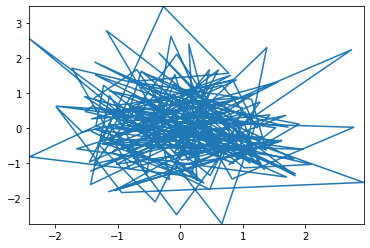

In [15]:
fig, ax = plt.subplots() 

data = np.random.randn(200,2) 
line, = ax.plot(data[0,0], data[0,1]) 

plt.xlim(min(data[:,0]), max(data[:,0])) 
plt.ylim(min(data[:,1]), max(data[:,1])) 

# plot the particles through scatters
points = Uniform_Particles_Construction(Width_Max, Height_Max, N)
plt.scatter(coord[:N], coord[N:2*N+1], c='g')
plt.show()

def animate(i): 
    line.set_data(data[:i,:].T) # update the data 
    return line, 


# Init only required for blitting to give a clean slate. 
def init(): 
    line.set_data(data[0,0], data[0,1]) 
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init, interval=25, blit=True) 
_ = HTML(ani.to_html5_video())